In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import DistilBertTokenizerFast,DistilBertForTokenClassification

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

In [5]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Yelp-dataset')

In [6]:
import zipfile
zip_ref=zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Yelp-dataset/Yelp.zip','r')
zip_ref.extractall('Yelp-dataset')
zip_ref.close()

In [7]:
train_path='/content/drive/MyDrive/Colab Notebooks/Yelp-dataset/Yelp-dataset/yelp_review_fine-grained_5_classes_csv/train.csv'
test_path='/content/drive/MyDrive/Colab Notebooks/Yelp-dataset/Yelp-dataset/yelp_review_fine-grained_5_classes_csv/test.csv'

In [136]:
train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)
train_df.head()

,class_index,review_text
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


In [9]:
train_df.shape

(650000, 2)

In [10]:
test_df.shape

(50000, 2)

### **Data Preparation**

In [137]:
train_df=train_df.groupby(by='class_index',group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=0))
test_df=test_df.groupby(by='class_index',group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=0))


In [138]:
train_df.shape

(32500, 2)

In [139]:
test_df.shape

(2500, 2)

In [140]:
bool=train_df.isnull().values.any()
if bool:
  print('There are some missing values')
else:
  print('No missing Values')
bool.sum()

No missing Values


0

In [141]:
train_df['class_index'].value_counts()

1    6500
2    6500
3    6500
4    6500
5    6500
Name: class_index, dtype: int64

In [142]:
stars=['*','**','***','****','*****']

In [143]:
texts=[]
for i in range(5):
  texts.append(train_df[train_df['class_index']==i+1]['review_text'].reset_index())
  texts[i].drop(['index'],inplace=True,axis=1)


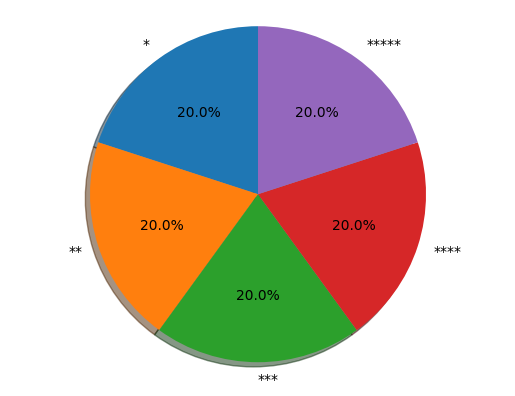

<Figure size 1500x1000 with 0 Axes>

In [144]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
sizes = [len(texts[i]) for i in range(5)]
ax1.pie(sizes,labels=stars, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.figure( figsize=(15,10) )
plt.show()

In [145]:
for i in range(0,5):
    print('\033[1m{} star review \033[0m \n'.format(i+1))
    print(texts[i]['review_text'][1], '\n')

1 star review  

This place was the worst place I ever went to. I took my laptop in because it would not boot. I am a patient person so I gave them two weeks before calling and checking in. I was told they needed another week. So I called a week and a half later and was told they had no record of my laptop!! After sitting on the phone with the lady, she found my laptop (unorganized much?) She said someone would call me soon with information on it. No one called. Basically two months after taking it in, I went into the store and demanded my laptop. It was in the back somewhere buried but taken apart. Definitely not fixed at all. He tried to convince me to leave it because it was dangerous for the laptop to be handled dismantled, but I was having none of it. They even had the nerve to charge me! I paid the fee for the quote because it was the only way to get my laptop back.\n\nBTW, I am referring to the place in MONONA, just because my profile said I was in Arizona for awhile does not me

In [146]:
train_df=train_df.sample(frac=1)

In [147]:
train_df.shape

(32500, 2)

In [148]:
train_df=train_df.reset_index()
train_df.drop(['index'],axis=1,inplace=True)


In [149]:
train_df

,class_index,review_text
0,4,LOVE this place...weekly customer. \n\nThat sa...
1,5,Was visiting Charlotte for business and checke...
2,2,Staying at TI is really a GREAT deal. The hote...
3,3,A true hole in the wall... Unpretentious and p...
4,1,Super rude. Took my mom's car in and they stol...
...,...,...
32495,2,"I love the concept. It is wonderful, especiall..."
32496,5,Bouchon may have ruined me for all other brunc...
32497,5,"I always get the beef tendon, uni with ikura, ..."
32498,5,"I brought my 4 watches in this store, 1 Repair..."


In [150]:
test_df=test_df.sample(frac=1).reset_index()

test_df.head()

,index,class_index,review_text
0,5570,5,These guys are normally backlogged five days a...
1,33593,5,GET THE LARGE PEPPERONI & MUSHROOM WITH DOUBLE...
2,25707,3,We had our wedding at the Fairmont Hotel Vanco...
3,22930,4,I really do just love this place...from the ve...
4,36996,5,"They were very friendly, showed up on time and..."


In [151]:
test_df.drop(['index'],axis=1,inplace=True)

In [152]:
test_df.head()

,class_index,review_text
0,5,These guys are normally backlogged five days a...
1,5,GET THE LARGE PEPPERONI & MUSHROOM WITH DOUBLE...
2,3,We had our wedding at the Fairmont Hotel Vanco...
3,4,I really do just love this place...from the ve...
4,5,"They were very friendly, showed up on time and..."


In [153]:
N_df=test_df
X_test=test_df.drop('class_index', axis=1)
Y_test=N_df.drop('review_text',axis=1)

In [154]:
X_test.head()

,review_text
0,These guys are normally backlogged five days a...
1,GET THE LARGE PEPPERONI & MUSHROOM WITH DOUBLE...
2,We had our wedding at the Fairmont Hotel Vanco...
3,I really do just love this place...from the ve...
4,"They were very friendly, showed up on time and..."


In [155]:
Y_test.head()

,class_index
0,5
1,5
2,3
3,4
4,5


In [156]:
train_df.dtypes

class_index     int64
review_text    object
dtype: object

In [ ]:
#train_df=pd.get_dummies(train_df,columns=['class_index'],drop_first=False)

In [ ]:
#train_df

In [ ]:
#train_df.rename(columns={'class_index_1': '1-star','class_index_2': '2-star','class_index_3': '3-star','class_index_4': '4-star','class_index_5': '5-star'},inplace=True)

In [ ]:
#train_df.columns


In [ ]:
#target_list=['1-star', '2-star', '3-star', '4-star', '5-star']

In [ ]:
#train_df[target_list].values

In [157]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05

In [168]:
X_train.keys()

Index(['class_index', 'review_text'], dtype='object')

In [158]:

#train_size = 0.8
#train_val = train_df.sample(frac=train_size, random_state=200).reset_index(drop=True)
#val_df = train_df.drop(train_val.index).reset_index(drop=True)
X_train=train_df

In [159]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [198]:
def new_function(df):
  #self.token=token
  embed=tokenizer.encode_plus(
    df,
    add_special_tokens=True,     
    max_length=512, 
    truncation=True, 
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids=True)
  ids=embed['input_ids']
  mask=embed['attention_mask']
  tok=['embed.token_type_ids']
  return ids,mask,tok

In [199]:
X_train.head()

,class_index,review_text
0,4,LOVE this place...weekly customer. \n\nThat sa...
1,5,Was visiting Charlotte for business and checke...
2,2,Staying at TI is really a GREAT deal. The hote...
3,3,A true hole in the wall... Unpretentious and p...
4,1,Super rude. Took my mom's car in and they stol...


In [182]:
embbd=tokenizer.encode_plus(
    X_train['review_text'][0],
    add_special_tokens=True,     
    max_length=512, 
    truncation=True, 
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids=True)
  


In [200]:

p,w,s=X_train['review_text'].map(new_function)

ValueError: ignored

IndexError: ignored

In [202]:
X_train.head()

,class_index,review_text
0,4,LOVE this place...weekly customer. \n\nThat sa...
1,5,Was visiting Charlotte for business and checke...
2,2,Staying at TI is really a GREAT deal. The hote...
3,3,A true hole in the wall... Unpretentious and p...
4,1,Super rude. Took my mom's car in and they stol...


In [201]:
X_input_ids=np.zeros((len(X_train),512))
X_attention_mask=np.zeros((len(X_train),512))
X_token_ids= np.zeros((len(X_train),512))
X_test_input_ids=np.zeros((len(X_test),512))
X_test_attention_mask=np.zeros((len(X_test),512))
X_test_token_ids=np.zeros((len(X_test),512))

In [203]:
X_input_ids.shape

(32500, 512)

In [204]:
X_test_input_ids.shape

(2500, 512)

In [205]:
def generate_Dataset(df, ids, masks, tok, token):
  for i,text in tqdm (enumerate(df['review_text'])):
    tokenized_text=tokenizer.encode_plus(
    text,
    add_special_tokens=True,     
    max_length=512, 
    truncation=True, 
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids=True)
    ids[i,:] = tokenized_text.input_ids 
    masks[i,:] = tokenized_text.attention_mask
    tok[i,:] =tokenized_text.token_type_ids
  return ids,masks,tok


In [206]:
X_input_ids, X_attention_mask, X_token_ids = generate_Dataset(X_train, X_input_ids, X_attention_mask,X_token_ids, tokenizer)
X_test_input_ids, X_test_attention_mask, X_test_token_ids = generate_Dataset(X_test, X_test_input_ids, X_test_attention_mask,X_test_token_ids, tokenizer)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [207]:
labels = pd.get_dummies(X_train,columns=['class_index'],drop_first=False)
labels.head()
Y_test_labels= pd.get_dummies(Y_test,columns=['class_index'],drop_first=False)
labels.head()

,review_text,class_index_1,class_index_2,class_index_3,class_index_4,class_index_5
0,LOVE this place...weekly customer. \n\nThat sa...,0,0,0,1,0
1,Was visiting Charlotte for business and checke...,0,0,0,0,1
2,Staying at TI is really a GREAT deal. The hote...,0,1,0,0,0
3,A true hole in the wall... Unpretentious and p...,0,0,1,0,0
4,Super rude. Took my mom's car in and they stol...,1,0,0,0,0


In [208]:
labels.rename(columns={'class_index_1': '1-star','class_index_2': '2-star','class_index_3': '3-star','class_index_4': '4-star','class_index_5': '5-star'},inplace=True)
Y_test_labels.rename(columns={'class_index_1': '1-star','class_index_2': '2-star','class_index_3': '3-star','class_index_4': '4-star','class_index_5': '5-star'},inplace=True)

In [209]:
labels.columns

Index(['review_text', '1-star', '2-star', '3-star', '4-star', '5-star'], dtype='object')

In [210]:
Y_test_labels.columns

Index(['1-star', '2-star', '3-star', '4-star', '5-star'], dtype='object')

In [211]:
target_list=['1-star', '2-star', '3-star', '4-star', '5-star']

In [212]:
label_array=np.array(labels[target_list].values).astype('float64')
label_array.dtype

dtype('float64')

In [213]:
Y_test_label_array=np.array(Y_test_labels[target_list].values).astype('float64')

In [214]:
Y_test_label_array

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [215]:
labels.head()

,review_text,1-star,2-star,3-star,4-star,5-star
0,LOVE this place...weekly customer. \n\nThat sa...,0,0,0,1,0
1,Was visiting Charlotte for business and checke...,0,0,0,0,1
2,Staying at TI is really a GREAT deal. The hote...,0,1,0,0,0
3,A true hole in the wall... Unpretentious and p...,0,0,1,0,0
4,Super rude. Took my mom's car in and they stol...,1,0,0,0,0


In [216]:
def X_testMapFunction(input_ids, attention_mask, token_id):
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_id
    }

In [217]:
X_input_ids.dtype

dtype('float64')

In [218]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input_ids, X_test_attention_mask, X_test_token_ids))
test_dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None))>

In [219]:
test_dataset=test_dataset.map(X_testMapFunction)

In [220]:
test_dataset.take(1)

<_TakeDataset element_spec={'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}>

In [221]:
test_dataset_batch = test_dataset.batch(16, drop_remainder=True)

In [222]:
test_dataset_batch.take(1)

<_TakeDataset element_spec={'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}>

In [223]:
# creating a data pipeline using tensorflow dataset utility, and creating batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attention_mask, X_token_ids, label_array))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [224]:
def RatingDatasetMapFunction(input_ids, attention_mask, token_id, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_id
    }, labels

In [225]:
dataset = dataset.map(RatingDatasetMapFunction) # converting to required format for tensorflow dataset 

In [226]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [227]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [228]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [229]:
dataset.take(1).element_spec[1]

TensorSpec(shape=(16, 5), dtype=tf.float64, name=None)

In [230]:
p = 0.8
train_size = int((len(X_train)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [231]:
train_size

1624

In [232]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

### **Model**

In [233]:
from transformers import TFDistilBertForSequenceClassification

In [234]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased') # bert base model with pretrained weights

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [235]:
!nvidia-smi

Mon May 15 03:52:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   1655MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [236]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))




Num GPUs Available:  1


In [ ]:
# Check if GPU is available

device=tf.device('GPU') if tf.config.list_physical_devices('GPU') else tf.device('CPU')

In [ ]:
device

In [237]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')
bert_embds = model.distilbert(input_ids, attention_mask=attn_masks)
pooled_output = tf.keras.layers.GlobalAveragePooling1D()(bert_embds[0])
# 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(pooled_output)
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

Rating_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
Rating_model.summary()
print(bert_embds[0])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

In [239]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-7)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [240]:
Rating_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
hist = Rating_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 510/1624 [========>.....................] - ETA: 38:58 - loss: 1.0878 - accuracy: 0.5045

In [ ]:
Rating_model.save('Rating_model')

### **Prediction**

In [ ]:
Rating_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Yelp-dataset/Rating_model')

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=512, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=target_list):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

In [ ]:
input_text = input('Enter Restaurant review here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(Rating_model, processed_data=processed_data)
print(f"Predicted Rating: {result}")

Enter Restraunt review here: I will give an average rating. Staff is really helpful
1/1 [==============================] - 0s 60ms/step
Predicted Sentiment: 3-star
